# Zee: Zero Effort Crowdsourcing for Indoor Localization

* This notebook implements the algorithm described in the Zee paper.

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import json
import shapely
import sklearn
import scipy
import shapely.vectorized
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from dataclasses import dataclass, field
from multiprocessing import Pool

%matplotlib inline

In [3]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [4]:
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The code is located in ./../../code


In [5]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions, compute_headings
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [8]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.sensors import estimate_acceleration_heading, estimate_heading_from_waypoints
from py_indoor_loc.utils import rotate, inverse_rotate
from pathlib import Path
from glob import glob
from py_indoor_loc.floor_map import transform_rotation

## Read Train/Test Assignment

In [9]:
train_test_assignment = pd.read_csv("../../data/output/20230902_train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

In [10]:
experiment_setup = pd.read_csv("../../data/output/20230902_semi_supervision_setup.csv", index_col=0)

for col in ["site_id", "floor_id", "dataset"]:
  experiment_setup[col] = experiment_setup[col].astype("category")

In [11]:
experiment_floors = experiment_setup[["site_id", "floor_id"]].drop_duplicates().values

In [12]:
print(f"The number of experiment floors is {experiment_floors.shape[0]}")

The number of experiment floors is 219


## Utilities

In [13]:
class DataListingUtil(object):

  def __init__(self, train_test_assignment: pd.DataFrame,
               experiment_setup: pd.DataFrame, data_dir: str | Path):
    self.train_test_assignment = train_test_assignment
    self.experiment_setup = experiment_setup

    if isinstance(data_dir, str):
      self.data_dir = Path(data_dir)
    else:
      self.data_dir = data_dir

  def list_unlabeled_tracks(self, site_id: str, floor_id: str,
                            p: float) -> list[str]:
    assert p >= 0 and p <= 1

    experiment_setup = self.experiment_setup

    return experiment_setup.loc[(experiment_setup["site_id"] == site_id) &
                                (experiment_setup["floor_id"] == floor_id) &
                                (experiment_setup["dataset"] == "unlabeled") &
                                (experiment_setup["floor_id"] == p),
                                "track_id"].values.tolist()
  
  def list_labeled_tracks(self, site_id: str, floor_id: str,
                          p: float) -> list[str]:
    assert p >= 0 and p <= 1

    experiment_setup = self.experiment_setup

    return experiment_setup.loc[(experiment_setup["site_id"] == site_id) &
                                (experiment_setup["floor_id"] == floor_id) &
                                (experiment_setup["dataset"] == "labeled") &
                                (experiment_setup["floor_id"] == p),
                                "track_id"].values.tolist()

  def list_train_tracks(self, site_id: str, floor_id: str):
    return self._list_track_by_dataset(site_id, floor_id, dataset="train")

  def list_test_track(self, site_id: str, floor_id: str):
    return self._list_track_by_dataset(site_id, floor_id, dataset="test")

  def _list_track_by_dataset(self, site_id: str, floor_id: str, dataset: str):
    train_test_assignment = self.train_test_assignment
    return train_test_assignment.loc[
        (train_test_assignment["site_id"] == site_id) &
        (train_test_assignment["floor_id"] == floor_id) &
        (train_test_assignment["dataset"] == dataset),
        "track_id"].values.tolist()

  def list_train_files(self, site_id: str, floor_id: str):
    return self.list_files(site_id, floor_id,
                            self.list_train_tracks(site_id, floor_id))

  def list_test_files(self, site_id: str, floor_id: str):
    return self.list_files(site_id, floor_id,
                            self.list_train_tracks(site_id, floor_id))

  def list_files(self, site_id: str, floor_id: str, track_list: list[str]):
    return [
        self.data_dir / site_id / floor_id / (track_id + ".txt")
        for track_id in track_list
    ]


## Data Preprocessing

In [14]:
data_dir = Path(f"../../data/train")
metadata_dir = Path(f"../../data/metadata")

In [15]:
data_listing_util = DataListingUtil(train_test_assignment=train_test_assignment,
                                    experiment_setup=experiment_setup,
                                    data_dir=data_dir)

### Estimating Map Rotation Angle

* The first step is to find the value of angle to perform map rotation such that Ox points to the magnetic North.

In [16]:
def compute_heading_diff(path_datas):
  sensor_headings = compute_headings(path_datas.ahrs)[:, 1]
  sensor_headings = np.degrees(sensor_headings)

  heading_timestamps = path_datas.magn[:, 0]
  waypoint_heading = estimate_heading_from_waypoints(path_datas.waypoint[:, 1:3])
  waypoint_timestamps = path_datas.waypoint[:, 0]
  assert len(waypoint_heading) == len(waypoint_timestamps) - 1

  # Approximate heading at waypoints by taking mean of sensor's heading values in the segment
  waypoint_sensor_headings = np.zeros_like(waypoint_heading, dtype=np.float32)
  for i in range(len(waypoint_heading)):
    prev_time, next_time = waypoint_timestamps[i], waypoint_timestamps[i + 1]
    segment_heading = sensor_headings[(heading_timestamps >= prev_time) & 
                                      (heading_timestamps < next_time)]
    
    if segment_heading.shape[0] == 0:
      waypoint_sensor_headings[i] = np.nan
    else:
      waypoint_sensor_headings[i] = np.mean(segment_heading)
  valid_mask = ~np.isnan(waypoint_sensor_headings)
  valid_waypoint_heading = waypoint_heading[valid_mask]
  valid_waypoint_sensor_heading = waypoint_sensor_headings[valid_mask]

  return valid_waypoint_heading - valid_waypoint_sensor_heading

In [17]:
if not os.path.exists("../../data/zee/floor_rotation_angles.csv"):
  estimated_rotation_angles = []

  for site_id, floor_id in tqdm(experiment_floors):
    train_tracks = train_test_assignment[
        (train_test_assignment["site_id"] == site_id) 
        & (train_test_assignment["floor_id"] == floor_id)
        & (train_test_assignment["dataset"] == "train")]
    train_track_id_list = train_tracks["track_id"].values

    train_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for track_id in train_track_id_list
    ]
    heading_diff = []

    for train_file in train_files:
      heading_diff.append(compute_heading_diff(read_data_file(train_file)))
    heading_diff_v = np.hstack(heading_diff)
    
    rotation_angle_degrees = heading_diff_v.mean()

    estimated_rotation_angles.append({
      "site_id": site_id,
      "floor_id": floor_id,
      "rotation_degree": rotation_angle_degrees
    })
  
  estimated_rotation_angle_df = pd.DataFrame(estimated_rotation_angles)
  estimated_rotation_angle_df.to_csv("../../data/zee/floor_rotation_angles.csv", index=False)

In [18]:
estimated_rotation_angle_df = pd.read_csv("../../data/zee/floor_rotation_angles.csv")

* Check the estimated rotation angle

In [61]:
site_id, floor_id = experiment_floors[0]

train_files = data_listing_util.list_train_files(site_id, floor_id)

rotation_angle_degrees = estimated_rotation_angle_df.loc[
    (estimated_rotation_angle_df["site_id"] == site_id) &
    (estimated_rotation_angle_df["floor_id"] == floor_id),
    "rotation_degree"].values[0]


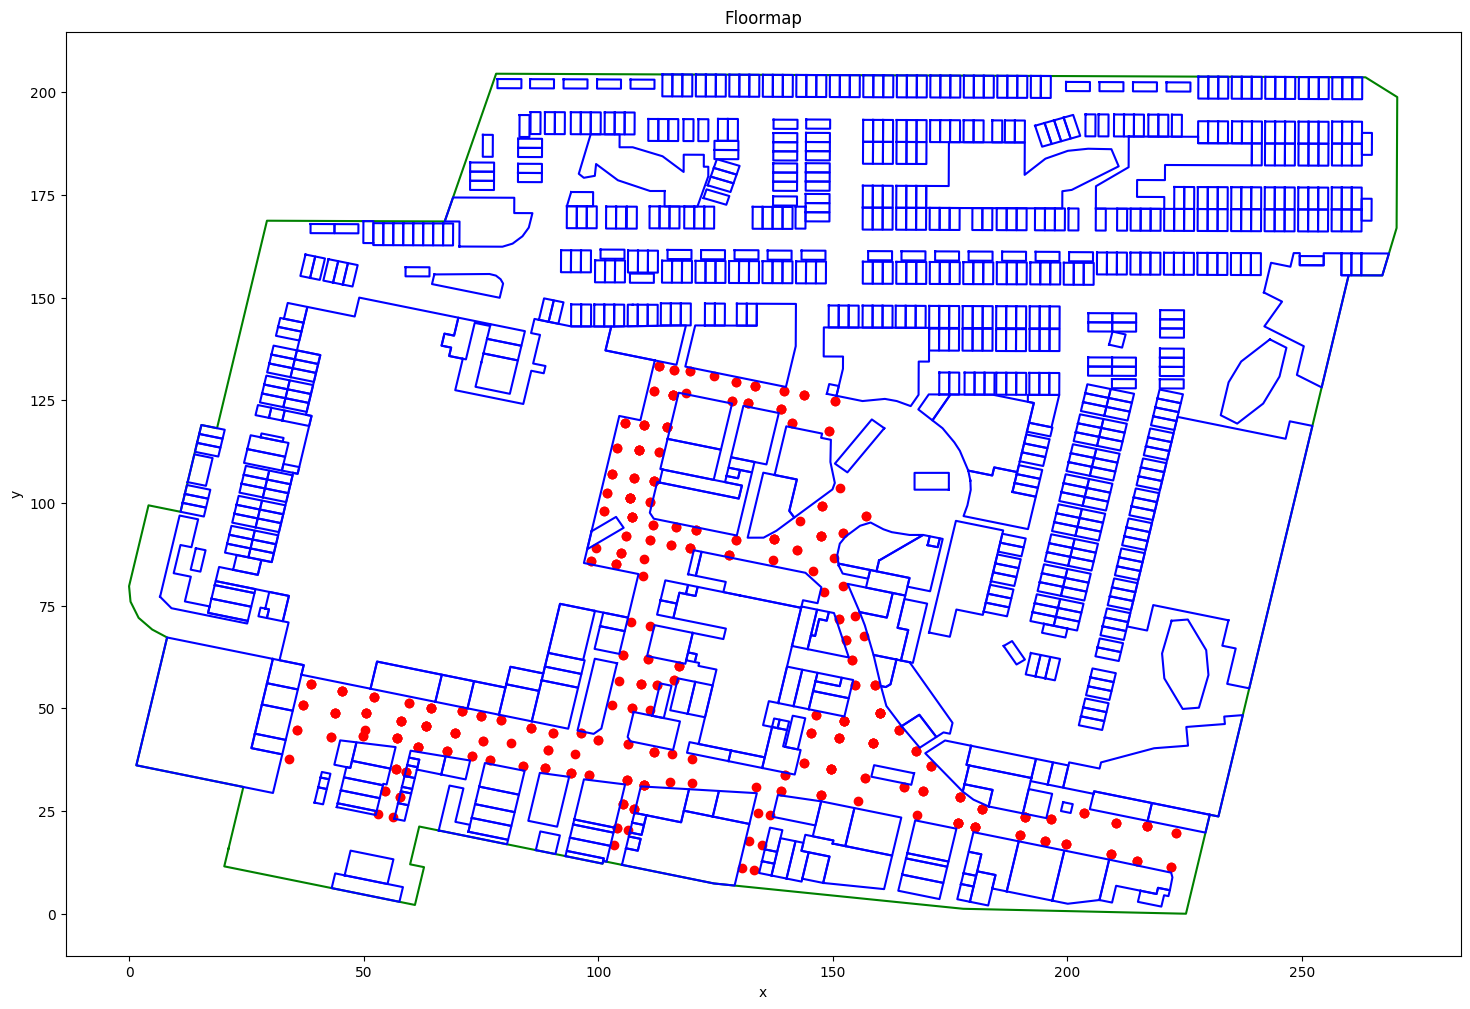

In [62]:
floor_info, floor_map = read_floor_data(str(metadata_dir / site_id / floor_id))

transform_func = transform_rotation(rotation_angle_degrees)
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map,
                                 floor_info,
                                 transform=transform_func)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
for file in train_files:
  path_datas = read_data_file(file)
  r_gt_location = transform_func(path_datas.waypoint[:, 1:])
  scale(r_gt_location,
        x_min,
        y_min,
        x_max,
        y_max,
        width_meter,
        height_meter,
        inplace=True)
  ax.scatter(r_gt_location[:, 0], r_gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

## Zee: Zero Supervision Scenario

## Zee: `p` Supervision Scenarios

* `p` is the percentage of available labeled data.

## Augmented Particle Filter

#### Search Space Extraction

* Search space is the space occupied by the floor excluding the space occupied by the stores.

In [63]:
from py_indoor_loc.zee import create_search_grid, SearchGrid

In [64]:
search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=3.0,
                                 tol=1.0)


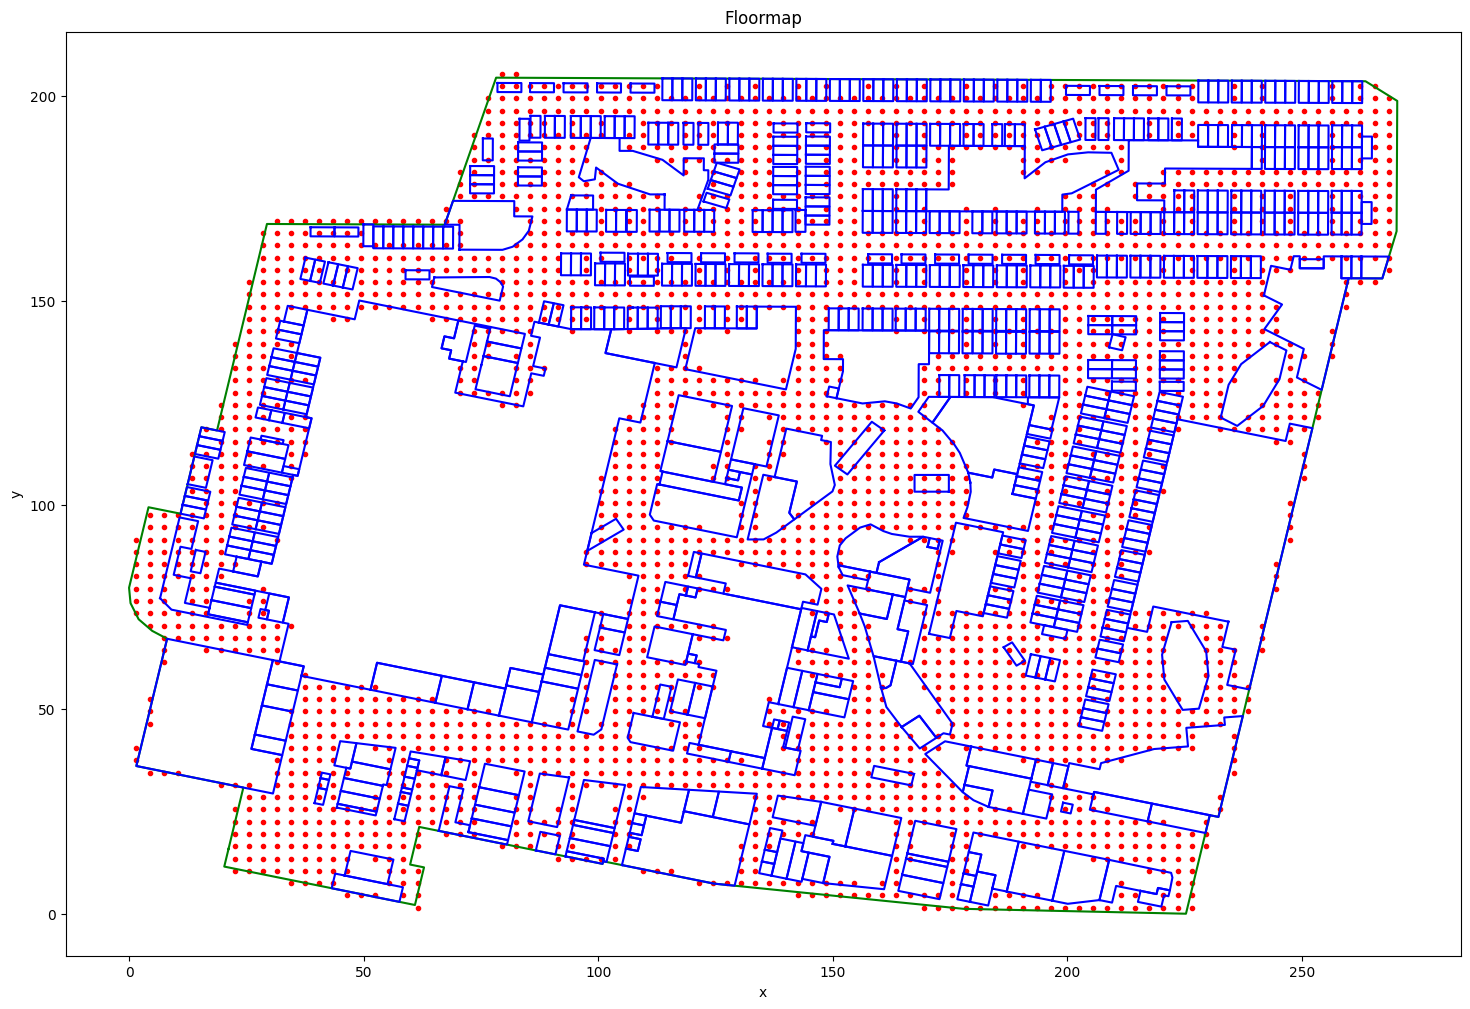

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding search grid
ax.scatter(search_grid.grid_points[:, 0], search_grid.grid_points[:, 1], marker=".", color="red", label="ss")

plt.ticklabel_format(useOffset=False)
plt.show()

### Running Zee

In [ ]:
from py_indoor_loc.zee import estimate_heading_offset, init_apf, run_apf
from py_indoor_loc.floor_map import inverse_scale

In [ ]:
def create_track_waypoints(sensor_ts: np.ndarray, history) -> pd.DataFrame:
  track_waypoints = []

  for step in history:
    step_point = step.particles[step.keep_mask, :2].mean(axis=0).tolist()
    step_time = sensor_ts[step.sample_index]
    track_waypoints.append((step_time, *step_point))

  return pd.DataFrame(track_waypoints, columns=["sys_ts", "x", "y"])

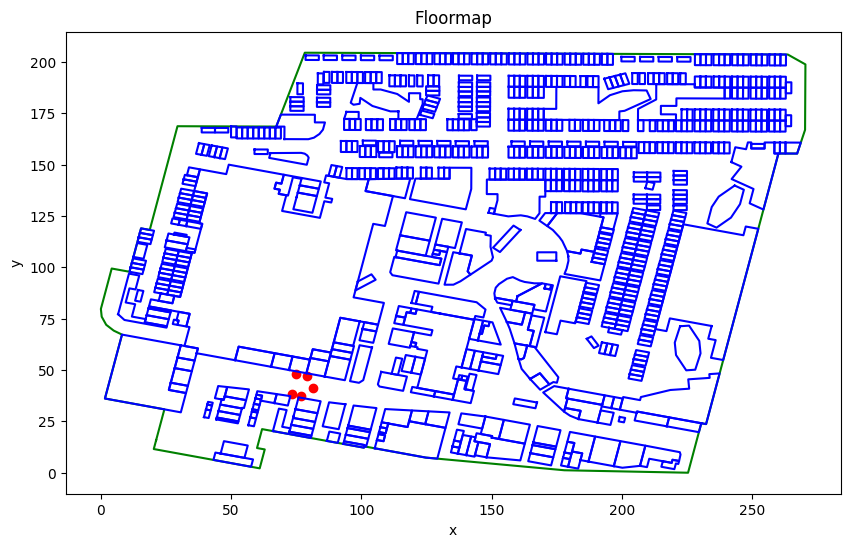

In [97]:
transform_func = transform_rotation(rotation_angle_degrees)
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map,
                                 floor_info,
                                 transform=transform_func)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
path_datas = read_data_file(train_files[10])
r_gt_location = scale(
    transform_func(path_datas.waypoint[:, 1:]),
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
)
ax.scatter(r_gt_location[:, 0], r_gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

In [109]:
for (site_id, floor_id) in tqdm(experiment_floors):
  print(site_id, floor_id)

  train_files = data_listing_util.list_train_files(site_id, floor_id)

  rotation_angle_degrees = estimated_rotation_angle_df.loc[
      (estimated_rotation_angle_df["site_id"] == site_id) &
      (estimated_rotation_angle_df["floor_id"] == floor_id),
      "rotation_degree"].values[0]

  transform_func = transform_rotation(rotation_angle_degrees)
  (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
  ) = extract_floor_map_geometries(floor_map,
                                  floor_info,
                                  transform=transform_func)
  
  search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=3.0,
                                 tol=1.0)

  for train_file in train_files:
    path_datas = read_data_file(train_file)
    acce, heading = estimate_acceleration_heading(path_datas.acce, path_datas.magn)
    heading_offset = estimate_heading_offset(acce[:50], fs=50)
    sensor_headings = heading[:50].mean()
    alpha = heading_offset - sensor_headings
    initial_particles = init_apf(search_grid, placement_offset_center=alpha)
    history = run_apf(acce, heading, initial_particles, search_grid, verbose=False)

    track_waypoints_df = create_track_waypoints(path_datas.acce[:, 0], history)
    artificial_location = inverse_scale(track_waypoints_df[["x", "y"]].values,
                                        x_min, y_min, x_max, y_max, width_meter, height_meter)
    track_waypoints_df["x"], track_waypoints_df["y"] = inverse_rotate(artificial_location[:, 0], artificial_location[:, 1], np.radians(rotation_angle_degrees))
    track_name = os.path.basename(train_file)[:-len(".txt")]
    os.makedirs(f"../../data/zee/train/{site_id}/{floor_id}/", exist_ok=True)
    track_waypoints_df.to_csv(f"../../data/zee/train/{site_id}/{floor_id}/{track_name}_waypoint.csv", 
                              index=False,
                              header=True)

  0%|          | 0/219 [00:00<?, ?it/s]

5a0546857ecc773753327266 B1


  0%|          | 1/219 [53:42<195:07:25, 3222.23s/it]

5a0546857ecc773753327266 F1


  1%|          | 2/219 [1:44:05<187:11:21, 3105.44s/it]

5a0546857ecc773753327266 F2


  1%|          | 2/219 [2:07:17<230:11:21, 3818.81s/it]


KeyboardInterrupt: 

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial particles")

step = history[-10]

ax.scatter(
    step.particles[step.keep_mask][:, 0],
    step.particles[step.keep_mask][:, 1],
    marker=".",
    color="red",
    label="particles",
)
ax.scatter(
    r_gt_location[-1, 0],
    r_gt_location[-1, 1],
    marker="o",
    color="green",
    label="ground truth",
)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

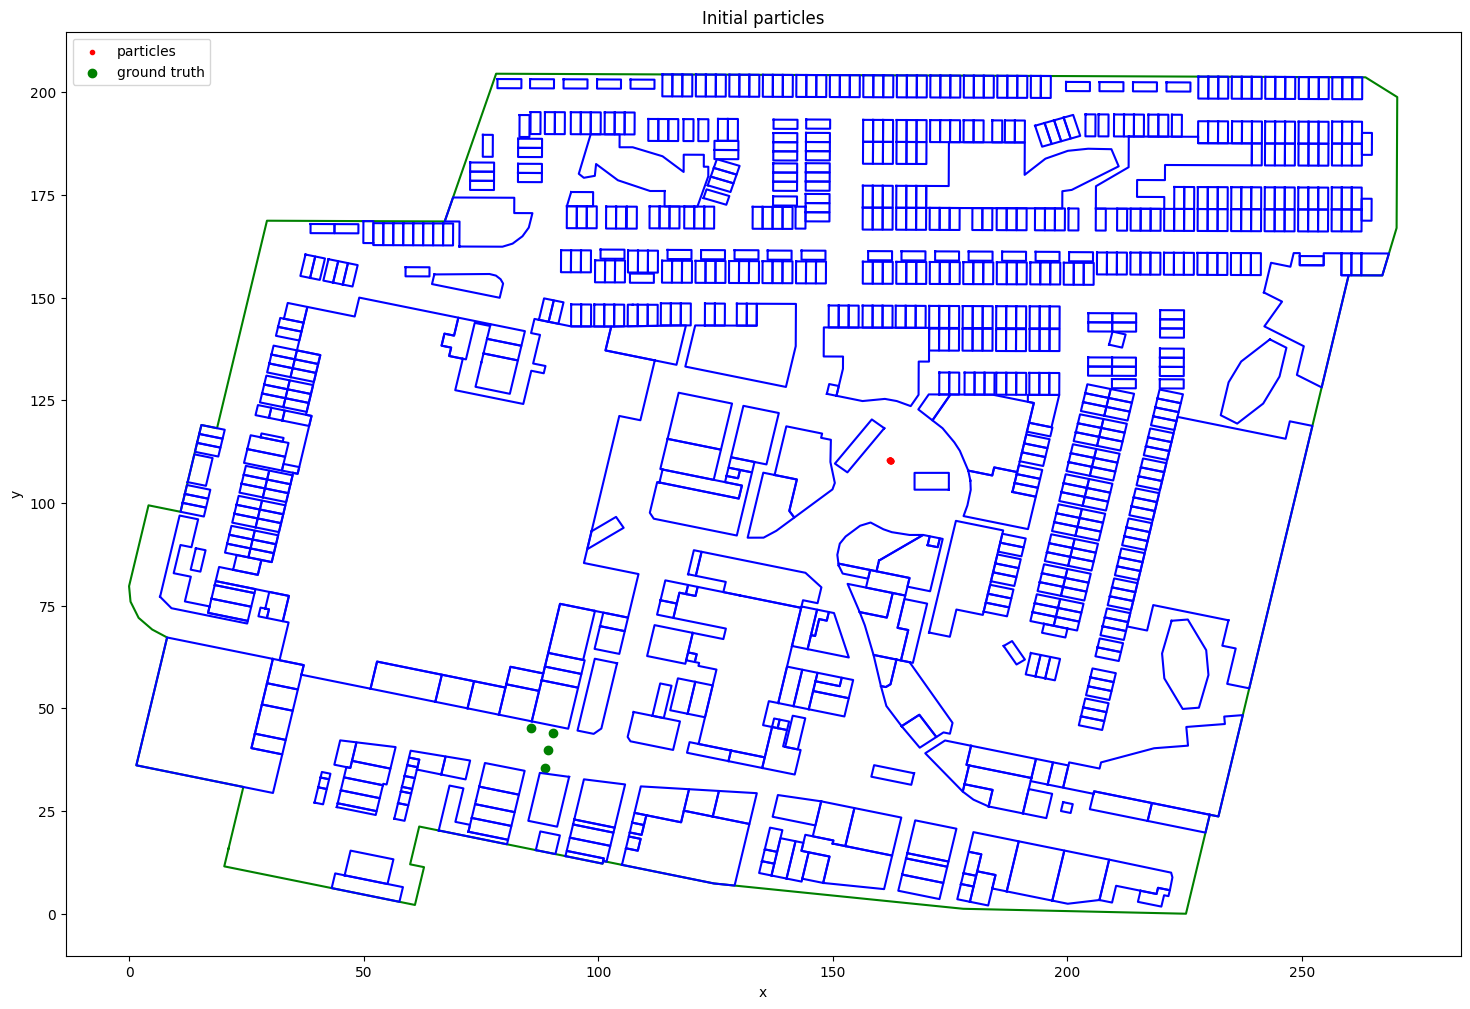

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial particles")

ax.scatter(
    unscaled[:, 0],
    unscaled[:, 1],
    marker=".",
    color="red",
    label="particles",
)
ax.scatter(
    r_gt_location[:, 0],
    r_gt_location[:, 1],
    marker="o",
    color="green",
    label="ground truth",
)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## Comparision with Manually Collected Data

In [80]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [81]:
def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  return wifi_df

In [82]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [83]:
waypoint_df = extract_waypoint_df(path_datas.waypoint)

In [84]:
wifi_df = extract_wifi_df(path_datas.wifi)

In [85]:
wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)

In [86]:
zee_wifi_waypoint_df = interpolate_wifi_waypoints(track_waypoints_df, wifi_df, max_offset_sec=2)

In [87]:
merged = pd.merge(wifi_waypoint_df, zee_wifi_waypoint_df, on="sys_ts", suffixes=["_manual", "_zee"])

In [88]:
errors = np.linalg.norm(merged[["x_manual", "y_manual"]].values - merged[["x_zee", "y_zee"]].values,
                        axis=1)


In [89]:
errors.mean()

33.389607332140244